# Micro Neural Net

In this notebook we slowly develop code that will allow us to build a neural net from scratch.

This notebook is based on the YouTube video by andrej karpathy available here: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

We first load in the Value class we have already built previously for computing gradients on computational graphs:

In [1]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

A first step towards building a neural net is defining a neuron. In our case, a neuron is just a set of weights of type Value, and one bias of type Value. When a set of inputs is passed to a neuron, a dot product is computed to obtain an activation. A non-linear function is then applied to the activation to obtain the final output of the neuron.

In [2]:
import math
import random


class Neuron:
    def __init__(self, number_of_inputs: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


inputs = [2.0, 3.0]
neuron = Neuron(2)
neuron(inputs)

Value(data=-0.825357489821143)

A *layer* of neurons is a set of *n* neurons, where each of the *n* neurons expects *m* inputs. 

In [3]:
class Layer:
    def __init__(self, neurons_in_layer: int, number_of_inputs_per_neuron: int):
        self.neurons = [Neuron(neurons_in_layer) for _ in range(number_of_inputs_per_neuron)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


inputs = [2.0, 3.0]
# a layer of 3 neurons, each of which expects 2 inputs
layer = Layer(3, 2)
layer(inputs)

[Value(data=-0.998222230018586), Value(data=-0.9974303210276446)]

Note that since one neuron produces one output, a layer of *n* neurons produces *n* outputs.

Just as a layer is a list of neurons, a multi-layer perceptron is simply a list of layers, where each layer can have a different number of neurons.

In [4]:
class MLP:
    def __init__(self, number_of_inputs: int, neurons_per_layer: list[int]):
        sz = [number_of_inputs] + neurons_per_layer
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(neurons_per_layer))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


inputs = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp_result: Value = mlp(inputs)
    
print('inputs:', inputs)
print('result:', mlp_result)

inputs: [2.0, 3.0, -1.0]
result: Value(data=-0.6070801651550387)


If we draw our neural network, we can see that it is quite complex already:

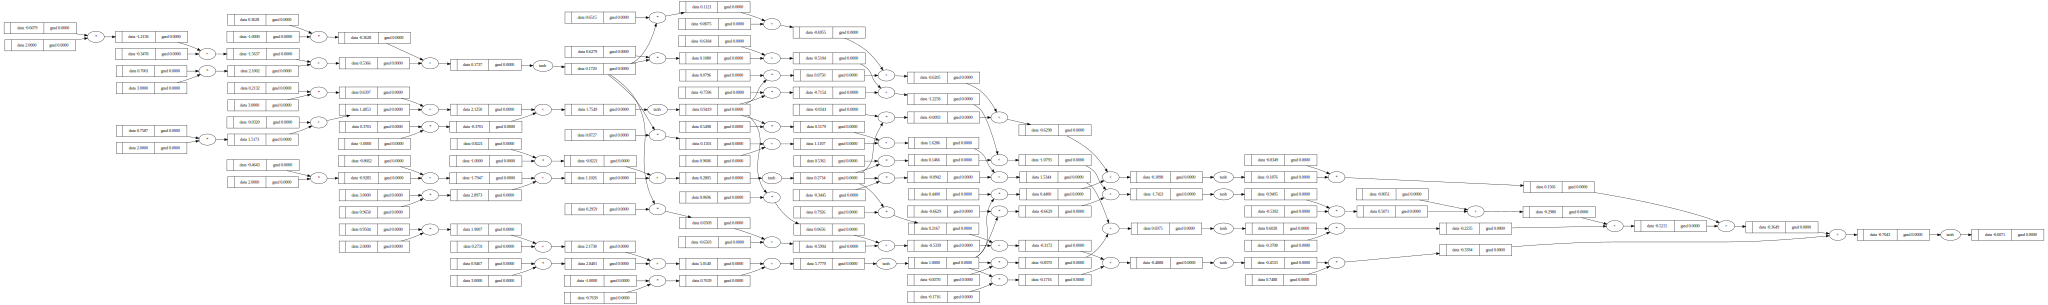

In [5]:
draw_dot(mlp_result)

Without a dataset, a neural network is not very useful. However, once we have a dataset, we can split the dataset into inputs and outputs and slowly train the neural net to produce the desired output whenever the corresponding input is presented to the network. 

For example, consider the following dataset:

In [6]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In this case, if the neural network sees the first row, we expect it to output 1.0. If it sees the second row, we expect to output -1.0, etc.

Since the weights of a neural network are initialied randomly, we expect the first forward pass through the network to be wildly incorrect:

In [7]:
y_predictions = [mlp(x) for x in xs]
y_predictions

[Value(data=-0.6070801651550387),
 Value(data=-0.4117068459579073),
 Value(data=-0.5215727519768003),
 Value(data=-0.5090026818761296)]

The only way for the neural network to perform better on the given dataset is to change the weights of the network. The process of changing the weights is called *tuning* the neural network.

Given a weight in the network, we can ask whether it should be turned up or down, and by how much. As a first step towards answering this question, we define one number called the *loss* that specifies how well a neural network is performing.

One commong loss function is the mean squared error, which is the squared difference between the prediction of the neural network and the expected correct output.

The list of individual losses look as follows:

In [8]:
[(yout - ygt) ** 2 for ygt, yout in zip(ys, y_predictions)]

[Value(data=2.582706657234747),
 Value(data=0.3460888350927934),
 Value(data=0.22889263165105223),
 Value(data=2.2770890939093515)]

The worse the neural network performs, the worse is the loss.

The total loss of the neural network is the sum of these individual losses:

In [9]:
loss: Value = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_predictions)])
print('loss:', loss)

loss: Value(data=5.4347772178879445)


The goal of training a neural network is minimize the loss to make it as close to zero as possible.

Because the loss is a Value object, we can call its .backward() function to evaluate the way in which a slight change to each weight in the network would affect the loss:

In [10]:
loss.backward()

For example, consider the gradient associated with the following neuron:

In [11]:
mlp.layers[0].neurons[0].w[0].grad

3.1459745904539824

When the gradient associated with a given weight is negative, this tells us that slightly *increasing* the value of the weight would bring down the loss. Conversely, when the gradient associated with a given weight is positive, this tells us that slightly *decreasing* the value of the weight would bring down the loss.

Since we have gradient information for each neuron, we can loop through the parameters of the neural network and change them accordingly:

In [12]:
tiny_amount = -0.1

for p in mlp.parameters():
    p.data += tiny_amount * p.grad

If we now run another forward pass and measure the loss again, we will see that the loss has gone down:

In [13]:
y_predictions = [mlp(x) for x in xs]
loss: Value = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_predictions)])
print('loss:', loss)

loss: Value(data=5.262466530403788)


Evidently, alternating in this way between forward and backward passes slowly improves the performance of the network. As a result, we can iterate this process in a loop called *gradient descent*:

In [14]:
for k in range(20):
    # forward pass
    y_predictions = [mlp(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, y_predictions))

    # backward pass - reset all gradients to zero to avoid overflow
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += tiny_amount * p.grad

loss: Value = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, y_predictions)])
print('loss:', loss)
print('\ny expected:', ys)
print('\ny predictions:', y_predictions)

loss: Value(data=0.028414587789922282)

y expected: [1.0, -1.0, -1.0, 1.0]

y predictions: [Value(data=0.9450804768947514), Value(data=-0.8809112321520747), Value(data=-0.9636844653840613), Value(data=0.9005139150944422)]


from the above, we can see that after just 10 iterations, the neural network is predicting its outputs almost exactly.

The tiny step that the parameters are tweaked by in each update step is called the *learning rate*. If the learning rate is too small, then many iterations will be required to train the network. If the learning rate is too large, then the network may never minimize its loss, since the sweet spot will be skipped over by the large learning rate step size.

To share a trained neural network, all that is required is the shape of the neural network and its parameters:

In [15]:
mlp.parameters()

[Value(data=-0.9139339210737832),
 Value(data=0.420509809731635),
 Value(data=1.3072307970081538),
 Value(data=-0.169683793079738),
 Value(data=0.5478029629359924),
 Value(data=-0.18149627630247056),
 Value(data=0.5491798148123613),
 Value(data=-0.29077450726381193),
 Value(data=-0.05218824613912343),
 Value(data=1.5028021892838492),
 Value(data=0.33978701130283756),
 Value(data=-0.6021744060097483),
 Value(data=0.5530378771107597),
 Value(data=0.9190101414967791),
 Value(data=-0.9643143937727574),
 Value(data=0.02520092171670458),
 Value(data=0.7901108331378006),
 Value(data=-0.6310342721861938),
 Value(data=0.6748698591736743),
 Value(data=-0.6007604722808431),
 Value(data=-0.4666236426882056),
 Value(data=0.9234002310577204),
 Value(data=0.864415265179873),
 Value(data=-0.7362552188534638),
 Value(data=-0.8969260543720647),
 Value(data=1.0537640035184246),
 Value(data=0.8895743976535965),
 Value(data=0.18243282155552573),
 Value(data=0.03950249840443058),
 Value(data=0.3070760341094